In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:12<00:00, 13.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


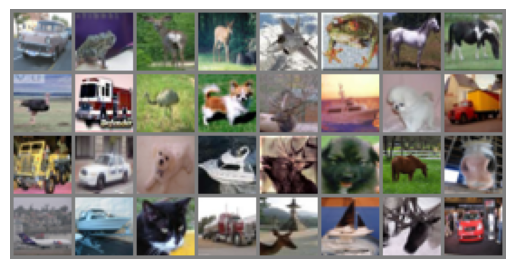

Labels: automobile frog deer deer airplane frog horse horse bird truck bird dog deer ship dog truck truck automobile dog ship deer dog horse horse airplane ship cat truck deer ship deer automobile


In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)


# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
classes = train_dataset.classes
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

In [ ]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

In [ ]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [ ]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [ ]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))


Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.5596 Generator Loss: 1.2975
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.5392 Generator Loss: 1.2438
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.7132 Generator Loss: 1.0621
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.5039 Generator Loss: 1.8832
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.5941 Generator Loss: 1.1005
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.6778 Generator Loss: 1.1554
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.7160 Generator Loss: 0.8557
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6310 Generator Loss: 1.1303
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.6671 Generator Loss: 0.9190
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.5178 Generator Lo

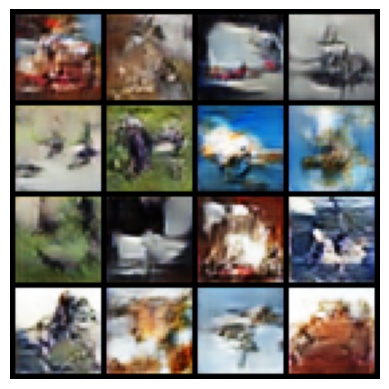

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()


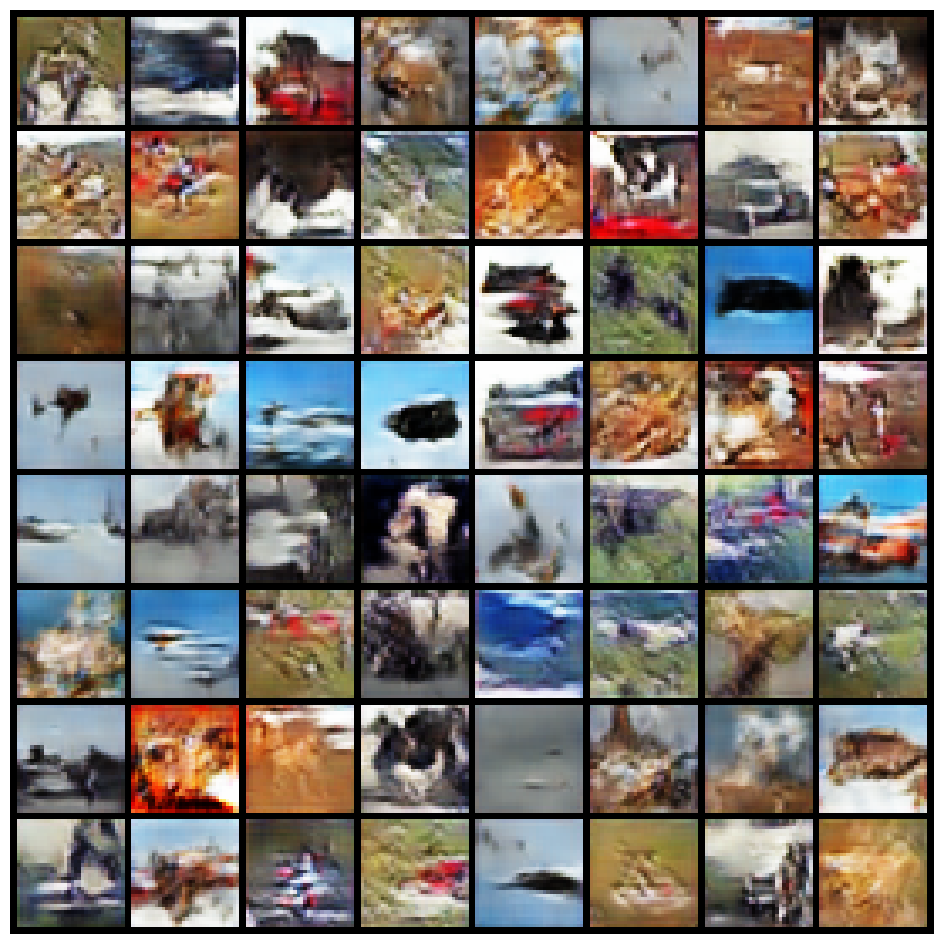

In [ ]:
# Chuyển generator sang chế độ eval
generator.eval()

with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)  # Tạo 64 ảnh để lưới ảnh lớn hơn
    generated_images = generator(z).detach().cpu()

# Tạo lưới ảnh với 8 hàng x 8 cột
grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)

# Thiết lập kích cỡ hiển thị to hơn
plt.figure(figsize=(12, 12))  # Điều chỉnh (12, 12) theo ý muốn để có kích thước to hớn
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [ ]:
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'epoch': epoch,  # Nếu muốn lưu số epoch để tiếp tục huấn luyện
    'd_loss': d_loss,  # Lưu các giá trị loss nếu cần
    'g_loss': g_loss
}, 'gan_checkpoint.pth')

In [ ]:
checkpoint = torch.load('gan_checkpoint.pth')

# Tải lại trạng thái của Generator, Discriminator và bộ tối ưu hóa
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

# start_epoch = checkpoint['epoch'] + 1
# d_loss = checkpoint['d_loss']
# g_loss = checkpoint['g_loss']